**PyTorch Medical Deep Learning with different Datasets**

In [ ]:
'''
Dataset is a data loading model, from original datasoruces that
are processed through the all non-random and random transforms to
generate tensors we can use and that have the smallest memory footprint.

Cache Dataset pre-loads the original data and applies all non-random
transformations into tensors loaded into memory all at once.
Subset of random transformations is applied tp cached components before use.
This is the highest performance dataset if all data fit in core meory.

Persistent Dataset processes original data sources thrugh transforms and
stores intermediate values to an on-disk persistence representation.
Persistent Dataset is similar to Dataset and with performance characterists
close to the Cache Dataset at the expense of disk storage.
'''

In [ ]:
!pip install monai
!pip install monai-weekly
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning~=2.0
!python -c "import monai; print(monai.__version__)"
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
import os, shutil, tempfile, PIL, logging, sys, time, glob
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import monai
from monai.apps import download_and_extract, DecathlonDataset
from monai.data import (DataLoader, ImageDataset, decollate_batch,
          CacheDataset, Dataset, PersistentDataset, LMDBDataset)
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.config import print_config
from monai.transforms import (
    AsDiscrete, Compose, EnsureChannelFirstd, LoadImaged, Orientationd,
    RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd, CropForegroundd)
from monai.utils import set_determinism
print_config()

In [3]:
''' seed/deterministic training for reproduceability '''
set_determinism(seed=0)
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!mkdir monai
os.environ['monai'] = '/content/monai'
dir = os.environ.get('monai')
rootdir = tempfile.mkdtemp() if dir is None else dir
rootdir

'/content/monai'

In [4]:
''' Training loop in PyTorch reuse code as in templates '''
def training_readiness(train_ds, val_ds):
    train_loader = DataLoader(
        train_ds, batch_size=2, shuffle=True, num_workers=8,)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

    device = torch.device("cuda:0")

    model = UNet(spatial_dims=3, in_channels=1, out_channels=2,
        channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2),
        num_res_units=2, norm=Norm.BATCH).to(device)
    loss_function = DiceLoss(include_background=False, to_onehot_y=True,
        softmax=True, squared_pred=True, batch=True, smooth_nr=0.00001,
        smooth_dr=0.00001, lambda_dice=0.5, lambda_ce=0.5,)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.00004,)

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])
    dice_metric = DiceMetric(
        include_background=True, reduction='mean', get_not_nans=False)

In [56]:
def training(train_ds, val_ds):
    train_loader = DataLoader(
        train_ds, batch_size=2, shuffle=True, num_workers=8,)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

    device = torch.device("cuda:0")

    model = UNet(
        spatial_dims=3, in_channels=1, out_channels=2,
        channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2),
        num_res_units=2, norm=Norm.BATCH).to(device)
    loss_function = DiceCELoss(
        include_background=False, to_onehot_y=True,
        softmax=True, squared_pred=True, batch=True, smooth_nr=0.00001,
        smooth_dr=0.00001, lambda_dice=0.5, lambda_ce=0.5,)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.00004,)

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])
    dice_metric = DiceMetric(
        include_background=True, reduction='mean', get_not_nans=False)

    max_epochs = 30
    val_interval = 1 # do validation for every epoch
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values, metric_values, epoch_times = [], [], []
    total_start = time.time()

    for epoch in range(20): #max_epochs
      epoch_start = time.time()
      model.train()
      epoch_loss = 0 ; step = 0
      for batch_data in train_loader:
          step_start = time.time()
          step += 1
          inputs, labels = (
              batch_data['image'].to(device), batch_data['label'].to(device))
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      epoch_loss /= step
      epoch_loss_values.append(epoch_loss)
      print(f'epoch {epoch +1} average loss: {epoch_loss:.4f}')

      if (epoch +1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
          for val_data in val_loader:
            val_inputs, val_labels = (
                val_data['image'].to(device), val_data['label'].to(device) )
            roi_size = (160, 160, 160) ; sw_batch_size = 4
            val_outputs = sliding_window_inference(
                val_inputs, roi_size, sw_batch_size, model)
            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
            val_labels = [post_label(i) for i in decollate_batch(val_labels)]
            dice_metric(y_pred=val_outputs, y=val_labels)

          metric = dice_metric.aggregate().item()
          dice_metric.reset()
          metric_values.append(metric)
          if metric > best_metric:
              best_metric = metric
              best_metric_epoch = epoch + 1
              torch.save(
                  model.state_dict(),
                  os.path.join(rootdir, 'best_metric_model.pth' ))
      print(f'time consuming of epoch {epoch +1} is \
            {(time.time() - epoch_start):.4f}')
    total_time = time.time() - total_start
    return (max_epochs, total_time, epoch_loss_values, metric_values, epoch_times)

In [6]:
'''  Download and prepare the Dataset '''
resource = 'https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar'
md5 = '410d4a301da4e5b2f6f86ec3ddba524e'
compressed_file = os.path.join(rootdir, 'Task09_Spleen.tar')
datadir = os.path.join(rootdir, 'Task09_Spleen')
if not os.path.exists(datadir):
  download_and_extract(resource, compressed_file, rootdir, md5)

Task09_Spleen.tar: 1.50GB [01:33, 17.2MB/s]                            

2025-07-06 15:27:37,683 - INFO - Downloaded: /content/monai/Task09_Spleen.tar


2025-07-06 15:27:40,517 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2025-07-06 15:27:40,518 - INFO - Writing into directory: /content/monai.


In [57]:
train_images = sorted(glob.glob(os.path.join(datadir, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(datadir, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [58]:
''' Prepare the transformations '''
train_transforms = Compose([
  LoadImaged(keys=['image', 'label']), EnsureChannelFirstd(keys=['image', 'label']),
  Orientationd(keys=['image', 'label'], axcodes='RAS'),
  Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.0), mode=('bilinear', 'nearest')),
  ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
  CropForegroundd(keys=['image', 'label'], source_key='image'),
  RandCropByPosNegLabeld(
      keys=['image', 'label'], label_key='label', spatial_size=(96, 96, 96),
      pos=1, neg=1, num_samples=4, image_key='image', image_threshold=0), ])

val_transforms = Compose([
  LoadImaged(keys=['image', 'label']), EnsureChannelFirstd(keys=['image', 'label']),
  Orientationd(keys=['image', 'label'], axcodes='RAS'),
  Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
  ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
  CropForegroundd(keys=["image", "label"], source_key='image') ])

**Training with Regular Dataset**

In [ ]:
train_ds = Dataset(data = train_files, transform = train_transforms)

val_ds = Dataset(data = val_files, transform = val_transforms)

(max_epochs, total_time, epoch_loss_values, metric_values, epoch_times) = \
          training(train_ds, val_ds)

In [ ]:
f'total training time of max epochs', \
max_epochs, total_time, epoch_loss_values, metric_values, epoch_times

**Training with Persistent Dataset**

In [ ]:
''' Use Persistent Dataset on transformed training and validation data
computed once and stored persistently across runs '''
persistent_cache = os.path.join(tempfile.mkdtemp(), 'persistent_cache')
set_determinism(seed=0)
train_persistence_ds = PersistentDataset(
    data=train_files, transform=train_transforms, cache_dir=persistent_cache)
val_persistence_ds = PersistentDataset(
    data=val_files, transform=train_transforms, cache_dir=persistent_cache)

(persistence_epochs, persistence_total_time, persistence_epoch_loss_values,
    persistence_metric_values, persistence_epoch_times) = \
        training(train_persistence_ds, val_persistence_ds)

f'total training time with Persistent Dataset of max epochs', \
persistence_epochs, persistence_total_time, persistence_epoch_loss_values, \
    persistence_metric_values, persistence_epoch_times

**Training with LMDB Dataset**

In [ ]:
''' Use Persistent Dataset on transformed training and validation data
computed once and stored persistently across runs '''
LMDB_cache = os.path.join(tempfile.mkdtemp(), 'lmdb_cache')
set_determinism(seed=0)

train_lmdb_ds = LMDBDataset(data=train_files, transform=train_transforms,
                    cache_dir=LMDB_cache, lmdb_kwargs = {'map_async': True})
val_lmdb_ds = LMDBDataset(data=val_files, transform=train_transforms,
                    cache_dir=LMDB_cache, lmdb_kwargs = {'map_async': True})

(lmdb_epochs, lmdb_total_time, lmdb_epoch_loss_values,
    lmdb_metric_values, lmdb_epoch_times) = training(train_lmdb_ds, val_lmdb_ds)

f'total training time with LMDB Dataset of max epochs', \
lmdb_epochs, lmdb_total_time, lmdb_epoch_loss_values, lmdb_epoch_times

**Training with Cache Dataset**

In [ ]:
set_determinism(seed=0)
cache_train_ds = CacheDataset(data = train_files,
  transform = train_transforms, cache_rate = 1.0, num_workers = 4)

cache_val_ds = CacheDataset(data = val_files,
  transform = val_transforms, cache_rate = 1.0, num_workers = 4)

(cache_max_epochs, cache_total_time, cache_epoch_loss_values, cache_metric_values,
      cache_epoch_times) = training(cache_train_ds, cache_val_ds)

In [ ]:
f'total training time with Cache Dataset of max epochs', cache_max_epochs,  \
cache_total_time, cache_epoch_loss_values, cache_metric_values, cache_epoch_times

**Training loss and validation metrics**

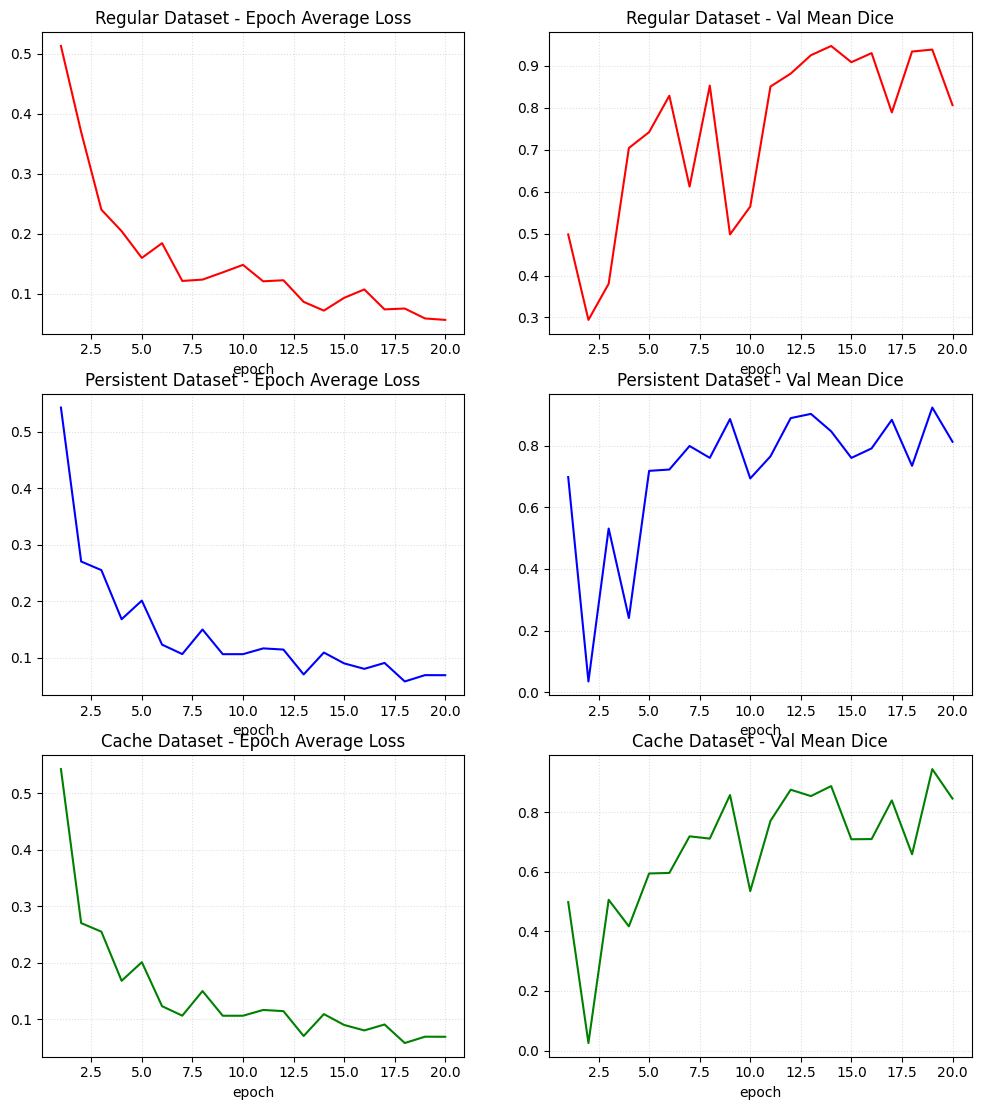

In [64]:
plt.figure('train', (12, 18))
plt.subplot(4, 2, 1) ; plt.title('Regular Dataset - Epoch Average Loss')
x, y = [i +1 for i in range(len(epoch_loss_values))], epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=.4, linestyle=':') ; plt.plot(x, y, color='red')

plt.subplot(4, 2, 2) ; plt.title('Regular Dataset - Val Mean Dice')
x, y = [i +1 for i in range(len(metric_values))], metric_values
plt.xlabel('epoch')
plt.grid(alpha=.4, linestyle=':') ;plt.plot(x, y, color='red')

plt.subplot(4, 2, 3) ; plt.title('Persistent Dataset - Epoch Average Loss')
x = [i +1 for i in range(len(persistence_epoch_loss_values))]
y = persistence_epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=.4, linestyle=':') ; plt.plot(x, y, color='blue')

plt.subplot(4, 2, 4) ; plt.title('Persistent Dataset - Val Mean Dice')
x = [i +1 for i in range(len(persistence_metric_values))]
y = persistence_metric_values
plt.xlabel('epoch')
plt.grid(alpha=.4, linestyle=':') ;plt.plot(x, y, color='blue')

plt.subplot(4, 2, 5) ; plt.title('Cache Dataset - Epoch Average Loss')
x = [i +1 for i in range(len(cache_epoch_loss_values))]
y = cache_epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=.4, linestyle=':') ; plt.plot(x, y, color='green')

plt.subplot(4, 2, 6) ; plt.title('Cache Dataset - Val Mean Dice')
x = [i +1 for i in range(len(cache_metric_values))]
y = cache_metric_values
plt.xlabel('epoch')
plt.grid(alpha=.4, linestyle=':') ;plt.plot(x, y, color='green')
plt.show()

**Total time and every epoch time**

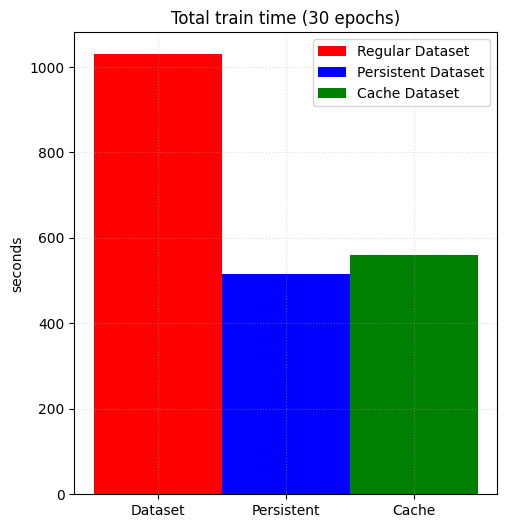

In [85]:
plt.figure('train', (12, 6))

plt.subplot(1, 2, 1)
plt.title(f'Total train time ({max_epochs} epochs)')
plt.bar('Dataset', total_time, 1, label='Regular Dataset', color='red')
plt.bar('Persistent', persistence_total_time, 1, label='Persistent Dataset', color='blue')
plt.bar('Cache', cache_total_time, 1, label='Cache Dataset', color='green')
plt.ylabel('seconds')
plt.grid(alpha = .4, linestyle=':')
plt.legend(loc = 'best')

'''
plt.subplot(1, 2, 2)
plt.title('Epoch Time')
x = [i +1 for i in range(len(epoch_times))]
plt.xlabel('epochs')
plt.ylabel('seconds')
plt.plot(x, max_epochs, label = 'Regular Dataset', color='red')
plt.plot(x, persistence_epochs, label = 'Persistent Dataset', color='blue')
plt.plot(x, cache_, label = 'Cache Dataset', color='green')
plt.plot(x, lmdb_epoch_times, label = 'LMDB Dataset', color='green')
plt.grid(alpha = .4, linestyle=':')
plt.legend(loc = 'best')
'''
plt.show()